# Ch12 | Agent & RAG：构建自主智能体

---

**目标：** 理解 LLM Agent 和 RAG 的工作原理

**核心问题：** 如何让 LLM 使用工具和检索信息？

---

## 本章内容

1. **ReAct 范式**：思考-行动-观察循环
2. **Tool Use**：让 LLM 调用函数
3. **RAG**：检索增强生成
4. **实战**：构建一个简单的 Agent

---

## 🎓 前置知识：LLM 的局限性

### 纯 LLM 的问题

经过前面所有训练，模型很强大了，但还有局限：

```
用户: "今天北京天气怎么样？"
LLM: "我无法获取实时信息..."  ❌ 没有最新数据

用户: "帮我计算 12345 × 67890"
LLM: "大约是 8.38 亿..."  ❌ 计算可能出错

用户: "帮我发一封邮件给老板"
LLM: "我无法执行实际操作..."  ❌ 不能操作外部系统
```

**LLM 的知识是"冻结"的，不能获取新信息或执行操作！**

### 解决方案 1：Agent（智能体）

给 LLM 配备**工具**，让它能够：

```
LLM + 工具 = Agent

工具示例:
- 搜索引擎: 获取最新信息
- 计算器: 精确计算
- 代码执行器: 运行代码
- API 调用: 操作外部系统
```

Agent 的工作流程（ReAct）：

```
问题 → 思考(Thought) → 行动(Action) → 观察(Observation) → 思考 → ...
```

### 解决方案 2：RAG（检索增强生成）

让 LLM 能够查询**外部知识库**：

```
用户问题
    ↓
检索相关文档 (向量搜索)
    ↓
把文档 + 问题一起给 LLM
    ↓
LLM 基于文档回答
```

**RAG = 让 LLM 有"开卷考试"的能力**

### 本章目标

- 理解 Agent 的架构（LLM + 工具 + 规划）
- 实现 Function Calling 格式
- 理解向量检索原理
- 构建完整的 Agent 和 RAG 系统

## 0. 环境准备

In [1]:
import json
import re
from typing import Dict, List, Callable
import numpy as np

print("环境准备完成！")

环境准备完成！


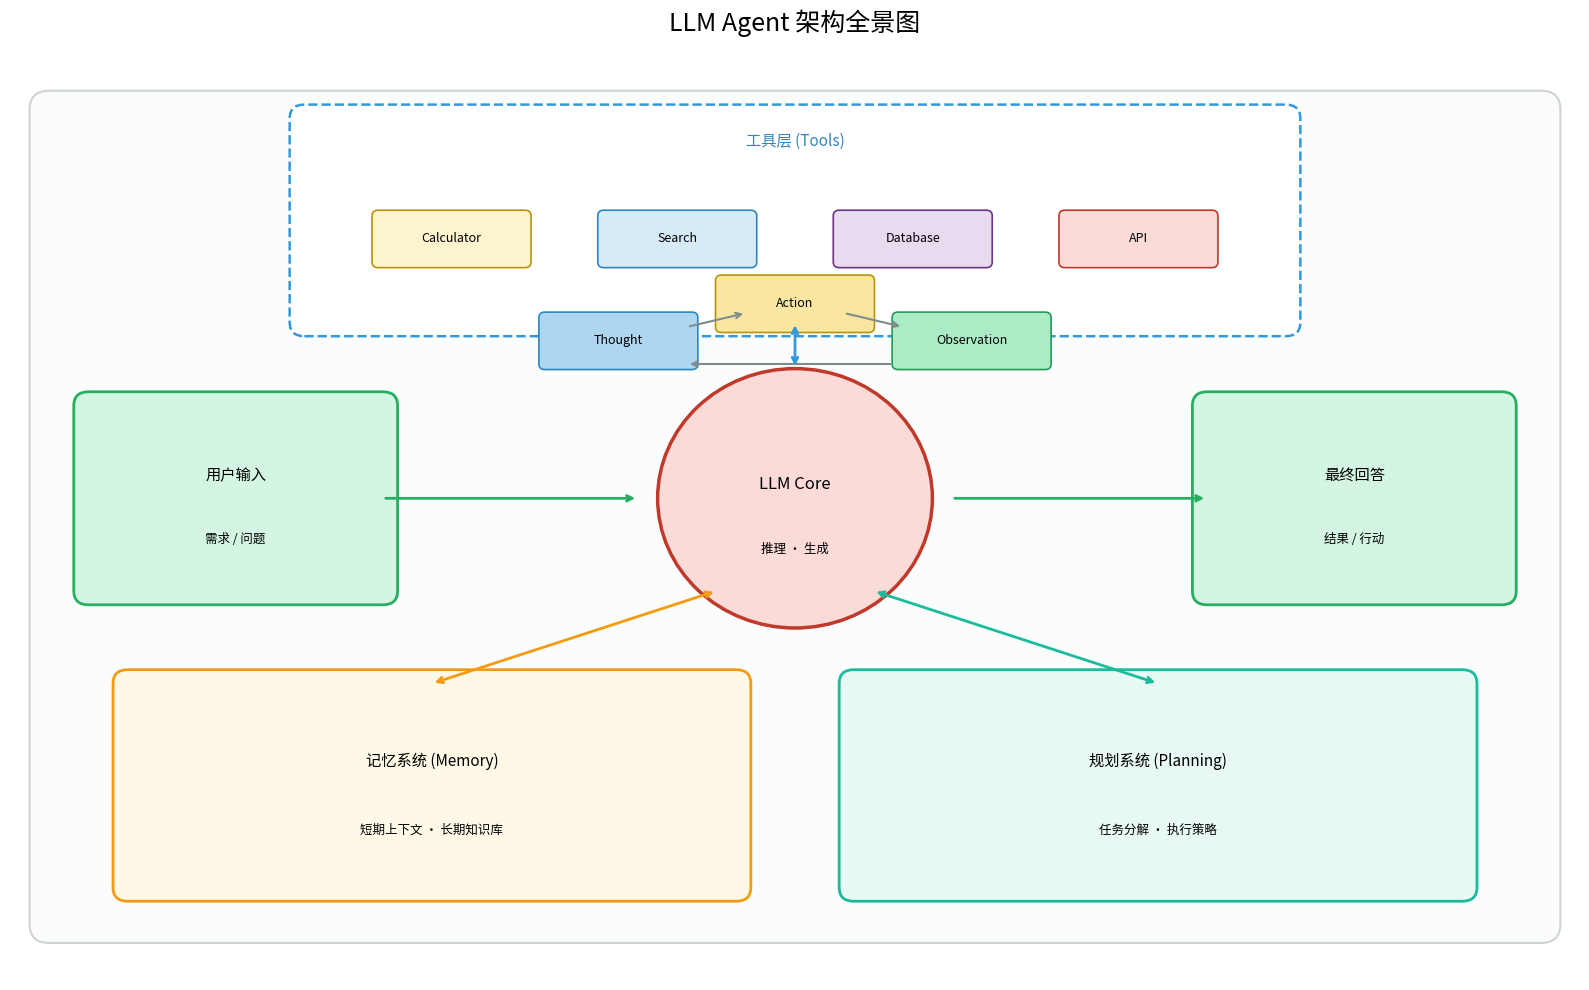


Agent 核心组件:
  1. LLM Core: 理解、推理、生成
  2. Tools: 扩展外部能力
  3. Memory: 上下文与知识
  4. Planning: 任务分解与策略执行

ReAct 循环: Thought → Action → Observation → ...


In [2]:
# Agent 架构全景图（专业版）
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle
from matplotlib import font_manager

import os
from matplotlib import font_manager as fm
import matplotlib as mpl
font_path = "../assets/fonts/NotoSansCJKsc-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

def draw_box(ax, x, y, w, h, title, body, face, edge):
    rect = FancyBboxPatch(
        (x, y), w, h, boxstyle="round,pad=0.15",
        facecolor=face, edgecolor=edge, linewidth=2
    )
    ax.add_patch(rect)
    ax.text(x + w / 2, y + h * 0.62, title,
            fontsize=11, fontweight="bold", ha="center", va="center")
    if body:
        ax.text(x + w / 2, y + h * 0.28, body,
                fontsize=9, ha="center", va="center")

def draw_chip(ax, x, y, text, face, edge):
    rect = FancyBboxPatch(
        (x - 0.75, y - 0.25), 1.5, 0.5, boxstyle="round,pad=0.06",
        facecolor=face, edgecolor=edge, linewidth=1.2
    )
    ax.add_patch(rect)
    ax.text(x, y, text, fontsize=9, ha="center", va="center")

def draw_arrow(ax, start, end, color, style="->", lw=2):
    ax.annotate(
        "", xy=end, xytext=start,
        arrowprops=dict(arrowstyle=style, color=color, lw=lw)
    )

def visualize_agent_architecture():
    """
    可视化 LLM Agent 的完整架构
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 10)
    ax.axis("off")

    frame = FancyBboxPatch(
        (0.4, 0.6), 15.2, 8.8, boxstyle="round,pad=0.2",
        facecolor="#FBFCFC", edgecolor="#D0D3D4", linewidth=1.5
    )
    ax.add_patch(frame)
    ax.set_title("LLM Agent 架构全景图", fontsize=18, fontweight="bold", pad=16)

    # 输入与输出
    draw_box(ax, 0.8, 4.2, 3.0, 2.0, "用户输入", "需求 / 问题", "#D5F5E3", "#27AE60")
    draw_box(ax, 12.2, 4.2, 3.0, 2.0, "最终回答", "结果 / 行动", "#D5F5E3", "#27AE60")

    # 核心：LLM
    core = Circle((8, 5.2), 1.4, facecolor="#FADBD8", edgecolor="#C0392B", linewidth=2.5)
    ax.add_patch(core)
    ax.text(8, 5.35, "LLM Core", fontsize=12, fontweight="bold", ha="center", va="center")
    ax.text(8, 4.65, "推理 · 生成", fontsize=9, ha="center", va="center")

    # 工具层
    tool_frame = FancyBboxPatch(
        (3.0, 7.1), 10.0, 2.2, boxstyle="round,pad=0.15",
        facecolor="white", edgecolor="#3498DB", linewidth=1.8, linestyle="--"
    )
    ax.add_patch(tool_frame)
    ax.text(8, 9.0, "工具层 (Tools)", fontsize=11, fontweight="bold",
            ha="center", color="#2E86C1")

    draw_chip(ax, 4.5, 8.0, "Calculator", "#FCF3CF", "#B7950B")
    draw_chip(ax, 6.8, 8.0, "Search", "#D6EAF8", "#2E86C1")
    draw_chip(ax, 9.2, 8.0, "Database", "#E8DAEF", "#6C3483")
    draw_chip(ax, 11.5, 8.0, "API", "#FADBD8", "#C0392B")

    # 记忆与规划
    draw_box(ax, 1.2, 1.0, 6.2, 2.2, "记忆系统 (Memory)", "短期上下文 · 长期知识库", "#FEF9E7", "#F39C12")
    draw_box(ax, 8.6, 1.0, 6.2, 2.2, "规划系统 (Planning)", "任务分解 · 执行策略", "#E8F8F5", "#1ABC9C")

    # ReAct 循环
    draw_chip(ax, 6.2, 6.9, "Thought", "#AED6F1", "#2E86C1")
    draw_chip(ax, 8.0, 7.3, "Action", "#F9E79F", "#B7950B")
    draw_chip(ax, 9.8, 6.9, "Observation", "#ABEBC6", "#239B56")
    draw_arrow(ax, (6.9, 7.05), (7.5, 7.2), "#7F8C8D", lw=1.5)
    draw_arrow(ax, (8.5, 7.2), (9.1, 7.05), "#7F8C8D", lw=1.5)
    draw_arrow(ax, (9.0, 6.65), (6.9, 6.65), "#7F8C8D", lw=1.5)

    # 主流程
    draw_arrow(ax, (3.8, 5.2), (6.4, 5.2), "#27AE60")
    draw_arrow(ax, (9.6, 5.2), (12.2, 5.2), "#27AE60")

    # 与系统模块交互
    draw_arrow(ax, (8.0, 6.6), (8.0, 7.1), "#3498DB", style="<->")
    draw_arrow(ax, (7.2, 4.2), (4.3, 3.2), "#F39C12", style="<->")
    draw_arrow(ax, (8.8, 4.2), (11.7, 3.2), "#1ABC9C", style="<->")

    plt.tight_layout()
    plt.show()

    print("\nAgent 核心组件:")
    print("  1. LLM Core: 理解、推理、生成")
    print("  2. Tools: 扩展外部能力")
    print("  3. Memory: 上下文与知识")
    print("  4. Planning: 任务分解与策略执行")
    print("\nReAct 循环: Thought → Action → Observation → ...")

visualize_agent_architecture()


---

## 1. ReAct 范式：思考-行动-观察

### 什么是 Agent？

Agent = LLM + 工具调用能力 + 规划能力

### ReAct 循环

```
1. Thought: 我需要做什么？
2. Action: 调用某个工具
3. Observation: 工具返回结果
4. ... (重复直到完成)
5. Final Answer: 最终回答
```

In [3]:
# ReAct 示例
react_example = """
问题 (Question): 湖北鄂州天气如何，需要带伞吗？
Question: What's the weather in Ezhou, Hubei, and should I bring an umbrella?

Thought: 我需要先查询湖北鄂州的天气 / I need to check the weather in Ezhou, Hubei.
Action: get_weather(city="湖北鄂州")
Observation: {"temperature": 25, "condition": "Rainy", "humidity": 80}

Thought: 鄂州有雨，建议带伞 / It's rainy, so I should recommend bringing an umbrella.
Action: None
Final Answer: 湖北鄂州当前 25°C 有雨，湿度 80%。建议带伞。
Final Answer (EN): It's 25°C and rainy in Ezhou, Hubei with 80% humidity. You should bring an umbrella.
"""

print("ReAct 示例:")
print(react_example)


ReAct 示例:

问题 (Question): 湖北鄂州天气如何，需要带伞吗？
Question: What's the weather in Ezhou, Hubei, and should I bring an umbrella?

Thought: 我需要先查询湖北鄂州的天气 / I need to check the weather in Ezhou, Hubei.
Action: get_weather(city="湖北鄂州")
Observation: {"temperature": 25, "condition": "Rainy", "humidity": 80}

Thought: 鄂州有雨，建议带伞 / It's rainy, so I should recommend bringing an umbrella.
Action: None
Final Answer: 湖北鄂州当前 25°C 有雨，湿度 80%。建议带伞。
Final Answer (EN): It's 25°C and rainy in Ezhou, Hubei with 80% humidity. You should bring an umbrella.



---

## 2. Tool Use：让 LLM 调用函数

### 工具定义

工具就是 Python 函数，需要：
1. 清晰的名称和描述
2. 参数说明
3. 返回值说明

In [4]:
# 定义一些工具
def calculator(expression: str) -> str:
    """
    计算数学表达式
    
    Args:
        expression: 数学表达式，如 "2 + 3 * 4"
    
    Returns:
        计算结果
    """
    try:
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"Error: {e}"

def search(query: str) -> str:
    """
    模拟搜索引擎
    
    Args:
        query: 搜索查询
    
    Returns:
        搜索结果
    """
    # 模拟搜索结果
    mock_results = {
        "python": "Python 是一种简洁易读的编程语言，常用于数据分析与后端开发。",
        "pytorch": "PyTorch 是一个深度学习框架，支持动态图与 GPU 加速。",
        "机器学习": "机器学习是人工智能的重要分支，通过数据学习模式并进行预测。",
        "湖北鄂州天气": "湖北鄂州天气：25°C，小雨，湿度 80%。",
    }
    
    for key, value in mock_results.items():
        if key in query.lower():
            return value
    return "未找到相关结果。"

def get_current_time() -> str:
    """
    获取当前时间
    
    Returns:
        当前时间字符串
    """
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 工具注册表
TOOLS = {
    "calculator": calculator,
    "search": search,
    "get_current_time": get_current_time,
}

# 测试工具
print("工具测试:")
print(f"  calculator('2 + 3 * 4') = {calculator('2 + 3 * 4')}")
print(f"  search('湖北鄂州天气') = {search('湖北鄂州天气')}")
print(f"  get_current_time() = {get_current_time()}")


工具测试:
  calculator('2 + 3 * 4') = 14
  search('湖北鄂州天气') = 湖北鄂州天气：25°C，小雨，湿度 80%。
  get_current_time() = 2026-01-18 10:51:33


In [5]:
# 工具描述（供 LLM 参考）
TOOL_DESCRIPTIONS = """
可用工具:

1. calculator(expression: str) -> str
   计算数学表达式。
   示例: calculator("2 + 3 * 4") -> "14"

2. search(query: str) -> str
   查询知识或搜索信息。
   示例: search("湖北鄂州天气") -> 返回天气信息

3. get_current_time() -> str
   获取当前日期与时间。
   示例: get_current_time() -> "2024-01-15 10:30:00"
"""

print(TOOL_DESCRIPTIONS)



可用工具:

1. calculator(expression: str) -> str
   计算数学表达式。
   示例: calculator("2 + 3 * 4") -> "14"

2. search(query: str) -> str
   查询知识或搜索信息。
   示例: search("湖北鄂州天气") -> 返回天气信息

3. get_current_time() -> str
   获取当前日期与时间。
   示例: get_current_time() -> "2024-01-15 10:30:00"



---

## 3. 简单的 Agent 实现

In [6]:
# Function Calling 格式详解
import json

def visualize_function_calling():
    """
    展示 OpenAI 风格的 Function Calling 格式
    这是现代 Agent 的标准接口
    """
    
    # 1. 工具定义格式（给 LLM 看的）
    tools_schema = [
        {
            "type": "function",
            "function": {
                "name": "get_weather",
                "description": "获取指定城市的天气信息",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "city": {
                            "type": "string",
                            "description": "城市名称，如 '湖北鄂州'"
                        },
                        "unit": {
                            "type": "string",
                            "enum": ["celsius", "fahrenheit"],
                            "description": "温度单位"
                        }
                    },
                    "required": ["city"]
                }
            }
        },
        {
            "type": "function", 
            "function": {
                "name": "calculate",
                "description": "计算数学表达式",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "expression": {
                            "type": "string",
                            "description": "数学表达式，如 '2 + 3 * 4'"
                        }
                    },
                    "required": ["expression"]
                }
            }
        }
    ]
    
    print("工具定义 Schema (JSON Schema 格式):")
    print("=" * 60)
    print(json.dumps(tools_schema[0], indent=2, ensure_ascii=False))
    
    # 2. LLM 调用工具的输出格式
    llm_tool_call = {
        "role": "assistant",
        "content": None,
        "tool_calls": [
            {
                "id": "call_abc123",
                "type": "function",
                "function": {
                    "name": "get_weather",
                    "arguments": '{"city": "湖北鄂州", "unit": "celsius"}'
                }
            }
        ]
    }
    
    print("\n\nLLM 返回的工具调用:")
    print("=" * 60)
    print(json.dumps(llm_tool_call, indent=2, ensure_ascii=False))
    
    # 3. 工具执行结果格式
    tool_result = {
        "role": "tool",
        "tool_call_id": "call_abc123",
        "content": '{"temperature": 25, "condition": "小雨", "humidity": 80}'
    }
    
    print("\n\n工具执行结果:")
    print("=" * 60)
    print(json.dumps(tool_result, indent=2, ensure_ascii=False))
    
    print("\n\n关键要点:")
    print("   1. 工具用 JSON Schema 描述参数")
    print("   2. LLM 返回结构化的 tool_calls")
    print("   3. 工具结果通过 tool_call_id 关联")
    print("   4. 这是 OpenAI/Claude 等 API 的标准格式")

visualize_function_calling()


工具定义 Schema (JSON Schema 格式):
{
  "type": "function",
  "function": {
    "name": "get_weather",
    "description": "获取指定城市的天气信息",
    "parameters": {
      "type": "object",
      "properties": {
        "city": {
          "type": "string",
          "description": "城市名称，如 '湖北鄂州'"
        },
        "unit": {
          "type": "string",
          "enum": [
            "celsius",
            "fahrenheit"
          ],
          "description": "温度单位"
        }
      },
      "required": [
        "city"
      ]
    }
  }
}


LLM 返回的工具调用:
{
  "role": "assistant",
  "content": null,
  "tool_calls": [
    {
      "id": "call_abc123",
      "type": "function",
      "function": {
        "name": "get_weather",
        "arguments": "{\"city\": \"湖北鄂州\", \"unit\": \"celsius\"}"
      }
    }
  ]
}


工具执行结果:
{
  "role": "tool",
  "tool_call_id": "call_abc123",
  "content": "{\"temperature\": 25, \"condition\": \"小雨\", \"humidity\": 80}"
}


关键要点:
   1. 工具用 JSON Schema 描述参数
   2. LLM 返回结构化的 too

In [7]:
class ProductionAgent:
    """
    生产级 ReAct Agent 实现（规则模拟版）
    
    核心循环:
    1. 接收用户输入
    2. LLM 思考 (Thought)
    3. 决定行动 (Action) 或 最终回答 (Final Answer)
    4. 如果是行动，执行工具并观察结果 (Observation)
    5. 重复直到得到最终答案
    """
    
    def __init__(self, tools: Dict[str, Callable], max_steps: int = 10):
        self.tools = tools
        self.max_steps = max_steps
        self.conversation_history = []
        self.simulation_mode = True
        
        # 构建系统提示词
        self.system_prompt = self._build_system_prompt()
    
    def _build_system_prompt(self) -> str:
        """构建包含工具描述的系统提示词"""
        tool_desc = "\n".join([
            f"- {name}: {func.__doc__.strip() if func.__doc__ else 'No description'}"
            for name, func in self.tools.items()
        ])
        
        return f"""你是一个可调用工具的助手。可用工具如下：

{tool_desc}

使用工具时，请用以下格式：
Thought: [你的思考]
Action: tool_name(arg1=\"value1\", arg2=\"value2\")

拿到工具结果后，可以继续思考或直接回答：
Thought: [你的分析]
Final Answer: [你的回答]

请保持 Thought / Action / Observation / Final Answer 的结构化输出。"""

    def parse_response(self, response: str) -> tuple:
        """
        解析 LLM 响应，提取 Thought, Action, 或 Final Answer
        
        Returns:
            (response_type, content)
            response_type: 'action', 'final_answer', or 'thought'
        """
        # 检查 Final Answer
        if "Final Answer:" in response:
            parts = response.split("Final Answer:")
            return ('final_answer', parts[-1].strip())
        
        # 检查 Action
        action_match = re.search(r'Action:\s*(\w+)\((.*?)\)', response, re.DOTALL)
        if action_match:
            tool_name = action_match.group(1)
            args_str = action_match.group(2)
            
            # 解析参数
            args = {}
            if args_str.strip():
                # 简单解析 key="value" 格式
                for match in re.finditer(r'(\w+)\s*=\s*["\']([^"\']*)["\']', args_str):
                    args[match.group(1)] = match.group(2)
                # 也支持无引号的数字
                for match in re.finditer(r'(\w+)\s*=\s*(\d+\.?\d*)', args_str):
                    if match.group(1) not in args:
                        args[match.group(1)] = float(match.group(2))
            
            return ('action', (tool_name, args))
        
        # 只有 Thought
        return ('thought', response)
    
    def execute_tool(self, tool_name: str, args: Dict) -> str:
        """执行工具并返回结果"""
        if tool_name not in self.tools:
            return f"Error: Tool '{tool_name}' not found. Available tools: {list(self.tools.keys())}"
        
        try:
            tool = self.tools[tool_name]
            if args:
                result = tool(**args)
            else:
                result = tool()
            return str(result)
        except Exception as e:
            return f"Error executing {tool_name}: {str(e)}"
    
    def simulate_llm(self, messages: List[Dict]) -> str:
        """
        规则模拟 LLM 响应（非真实模型）
        实际使用时替换为真正的 LLM API 调用
        """
        # 获取最后一条用户消息或工具结果
        last_msg = messages[-1]['content'] if messages else ""
        
        # 基于简单规则模拟响应
        if "weather" in last_msg.lower() or "天气" in last_msg:
            return """Thought: 这是天气问题，需要调用 get_weather 工具。
Action: get_weather(city=\"湖北鄂州\")"""
        
        if "calculate" in last_msg.lower() or "计算" in last_msg or any(op in last_msg for op in ['+', '-', '*', '/']):
            # 提取数学表达式
            expr_match = re.search(r'(\d[\d\+\-\*\/\(\)\.\s]*)', last_msg)
            if expr_match:
                expression = expr_match.group(1).strip()
                return f"""Thought: 这是数学问题，需要调用 calculator。
Action: calculator(expression=\"{expression}\")"""
            return """Thought: 我没识别出明确的数学表达式。
Final Answer: 没找到可计算的表达式，请明确给出。"""
        
        if "Observation:" in last_msg:
            # 工具返回后，给出最终答案
            observation = last_msg.split("Observation:", 1)[-1].strip()
            return f"""Thought: 已获得工具结果，可以整理回答。
Final Answer: 结果是 {observation}"""
        
        return f"""Thought: 这是一般问题，直接回答即可。
Final Answer: 我可以帮助回答你的问题：{last_msg[:50]}..."""
    
    def run(self, user_query: str, verbose: bool = True) -> str:
        """
        运行 Agent 主循环
        
        Args:
            user_query: 用户问题
            verbose: 是否打印详细过程
        
        Returns:
            最终回答
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"用户问题: {user_query}")
            if self.simulation_mode:
                print("模式: 规则模拟（非真实 LLM）")
            print(f"{'='*60}")
        
        # 初始化对话
        messages = [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": user_query}
        ]
        
        for step in range(self.max_steps):
            if verbose:
                print(f"\n步骤 {step + 1}:")
                print("-" * 40)
            
            # 获取 LLM 响应
            response = self.simulate_llm(messages)
            
            if verbose:
                print(f"模拟输出:\n{response}")
            
            # 解析响应
            response_type, content = self.parse_response(response)
            
            if response_type == 'final_answer':
                if verbose:
                    print(f"\n{'='*60}")
                    print(f"最终回答: {content}")
                    print(f"{'='*60}")
                return content
            
            if response_type == 'action':
                tool_name, args = content
                if verbose:
                    print(f"\n执行工具: {tool_name}({args})")
                
                # 执行工具
                result = self.execute_tool(tool_name, args)
                
                if verbose:
                    print(f"观察结果: {result}")
                
                # 将结果添加到对话
                messages.append({"role": "assistant", "content": response})
                messages.append({"role": "user", "content": f"Observation: {result}"})
            else:
                messages.append({"role": "assistant", "content": response})
        
        return "已达到最大步数，未产生最终答案。"

# 测试生产级 Agent
print("创建生产级 Agent（规则模拟版）...")
agent = ProductionAgent(TOOLS)

# 运行测试
print("\n" + "="*60)
print("测试 1: 数学计算")
agent.run("请计算 15 * 7 + 23")

print("\n" + "="*60)
print("测试 2: 一般问题")
agent.run("什么是 Python 编程语言？")


创建生产级 Agent（规则模拟版）...

测试 1: 数学计算

用户问题: 请计算 15 * 7 + 23
模式: 规则模拟（非真实 LLM）

步骤 1:
----------------------------------------
模拟输出:
Thought: 这是数学问题，需要调用 calculator。
Action: calculator(expression="15 * 7 + 23")

执行工具: calculator({'expression': '15 * 7 + 23'})
观察结果: 128

步骤 2:
----------------------------------------
模拟输出:
Thought: 已获得工具结果，可以整理回答。
Final Answer: 结果是 128

最终回答: 结果是 128

测试 2: 一般问题

用户问题: 什么是 Python 编程语言？
模式: 规则模拟（非真实 LLM）

步骤 1:
----------------------------------------
模拟输出:
Thought: 这是一般问题，直接回答即可。
Final Answer: 我可以帮助回答你的问题：什么是 Python 编程语言？...

最终回答: 我可以帮助回答你的问题：什么是 Python 编程语言？...


'我可以帮助回答你的问题：什么是 Python 编程语言？...'

---

## 4. RAG：检索增强生成

### 什么是 RAG？

RAG = Retrieval-Augmented Generation（检索增强生成）

**核心思路**：先检索相关内容，再把文档作为上下文交给 LLM 生成答案。

```
1. 用户提问
2. 从知识库检索相关文档
3. 将文档拼接进提示词（Prompt）
4. LLM 基于文档回答
```

### 为什么需要 RAG？

- **知识时效**：模型知识过期时，通过检索补充最新信息
- **降低幻觉**：把答案锚定在可查证的文档上
- **可追溯**：方便引用来源，提升可信度

### 向量存储Vector database的原理

- **向量化**：把文本/图片等内容转换为向量表示（Embedding）
- **存储**：向量与元数据一起写入向量数据库
- **索引**：建立 ANN/HNSW/IVF 等索引，加速相似度检索
- **查询**：问题向量化，计算相似度，返回 Top-K 文档

![Vector DB 示意图（来源：AltexSoft）](assets/vectordb.png)

图片来源：AltexSoft

### 关键组成与流程

- **文档切分 (Chunking)**：控制上下文长度，提升检索精度
- **向量化 (Embedding)**：将文本转换为向量表示
- **向量检索 (Top-K)**：从向量数据库召回最相关片段
- **重排 (Rerank)**：二次排序，过滤噪声
- **提示词构造**：把检索结果组织成可读上下文

### 常见参数

- `chunk_size` / `chunk_overlap`
- `top_k`
- `temperature`
- `rerank_model`

### 局限与评估

- **召回不足**：检索不到就无法回答
- **提示注入**：需要对文档做安全过滤
- **评估指标**：Recall@K、Answer Faithfulness、引用准确性

### 说明

> 本章 RAG 示例为**教学模拟**，未接入真实向量数据库与嵌入模型。
> 真实项目中可使用 `sentence-transformers` + FAISS/Milvus/Chroma 等组件替换。


In [8]:
class VectorRAG:
    """
    基于向量检索的 RAG 系统（教学模拟）
    
    核心流程:
    1. 文档 -> 向量化 -> 存入向量数据库
    2. 查询 -> 向量化 -> 相似度搜索 -> 返回 Top-K
    3. 将检索结果作为上下文给 LLM
    """
    
    def __init__(self, embedding_dim: int = 64):
        self.embedding_dim = embedding_dim
        self.documents = []
        self.embeddings = []
        
        # 模拟嵌入模型（实际使用 sentence-transformers 等）
        np.random.seed(42)
        self.word_embeddings = {}
    
    def _get_word_embedding(self, word: str) -> np.ndarray:
        """获取词向量（模拟）"""
        word = word.lower()
        if word not in self.word_embeddings:
            # 为每个词生成一个伪随机向量
            np.random.seed(hash(word) % 2**32)
            self.word_embeddings[word] = np.random.randn(self.embedding_dim)
        return self.word_embeddings[word]
    
    def _embed_text(self, text: str) -> np.ndarray:
        """将文本转换为向量（简化版：词向量平均）"""
        words = re.findall(r'\w+', text.lower())
        if not words:
            return np.zeros(self.embedding_dim)
        
        word_vecs = [self._get_word_embedding(w) for w in words]
        return np.mean(word_vecs, axis=0)
    
    def add_documents(self, documents: List[str]):
        """添加文档到知识库"""
        for doc in documents:
            self.documents.append(doc)
            embedding = self._embed_text(doc)
            self.embeddings.append(embedding)
        
        print(f"添加了 {len(documents)} 个文档，共 {len(self.documents)} 个")
    
    def search(self, query: str, top_k: int = 3) -> List[tuple]:
        """
        向量相似度搜索
        
        Returns:
            List of (document, similarity_score)
        """
        if not self.embeddings:
            return []
        
        # 计算查询向量
        query_vec = self._embed_text(query)
        
        # 计算余弦相似度
        similarities = []
        for i, doc_vec in enumerate(self.embeddings):
            sim = np.dot(query_vec, doc_vec) / (
                np.linalg.norm(query_vec) * np.linalg.norm(doc_vec) + 1e-8
            )
            similarities.append((i, sim))
        
        # 排序并返回 top_k
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        results = []
        for idx, sim in similarities[:top_k]:
            results.append((self.documents[idx], sim))
        
        return results
    
    def generate_answer(self, query: str, top_k: int = 3) -> str:
        """
        RAG 完整流程：检索 + 生成
        """
        print(f"\n{'='*60}")
        print(f"查询: {query}")
        print(f"{'='*60}")
        
        # Step 1: 检索
        print("\nStep 1: 向量检索")
        print("-" * 40)
        results = self.search(query, top_k)
        
        if not results:
            return "未找到相关文档。"
        
        for i, (doc, score) in enumerate(results):
            print(f"  [{i+1}] 相似度: {score:.4f}")
            print(f"      {doc[:80]}{'...' if len(doc) > 80 else ''}")
        
        # Step 2: 构建提示词
        print("\nStep 2: 构建 Prompt")
        print("-" * 40)
        
        context = "\n".join([f"[{i+1}] {doc}" for i, (doc, _) in enumerate(results)])
        
        prompt = f"""请基于以下上下文回答问题。若上下文中没有答案，请明确说明无法回答。

上下文:
{context}

问题: {query}

回答:"""
        
        print(f"Prompt 长度: {len(prompt)} 字符")
        print(f"包含 {len(results)} 个参考文档")
        
        # Step 3: 生成回答（模拟）
        print("\nStep 3: LLM 生成回答（模拟）")
        print("-" * 40)
        
        # 模拟 LLM 回答
        answer = f"根据检索到的文档，{results[0][0][:100]}..."
        print(f"回答: {answer}")
        
        return answer

# 创建 RAG 系统并添加知识库
print("构建 RAG 知识库...")
print("=" * 60)

rag = VectorRAG(embedding_dim=64)

# 添加文档
knowledge_base = [
    "Python 是一门高级解释型语言，强调可读性与开发效率。",
    "机器学习是人工智能的重要分支，通过数据学习模式并进行预测。",
    "PyTorch 是 Facebook AI Research 开源的深度学习框架，支持动态计算图。",
    "PyTorch 提供 GPU 加速张量与自动求导（autograd）。",
    "Transformer 使用自注意力机制，源自 2017 年论文《Attention Is All You Need》。",
    "GPT 是预训练的生成式 Transformer 模型家族，GPT-4 是代表版本。",
    "RAG 将检索系统与生成模型结合，提升回答准确性与可追溯性。",
    "向量数据库（如 FAISS、Milvus、Chroma）用于高效相似度检索。",
    "LangChain 提供构建 LLM 应用的链式组件与工具封装。",
    "微调（Fine-tuning）是用小规模任务数据适配大模型能力。",
    "RLHF 是用人类反馈对齐模型输出的训练方法。",
    "知识库需要切分、去噪和版本管理，以保证检索质量。",
]

rag.add_documents(knowledge_base)

# 测试 RAG
print("\n" + "="*60)
print("测试 RAG 系统")
print("="*60)

rag.generate_answer("PyTorch 是什么，由谁开发？")


构建 RAG 知识库...
添加了 12 个文档，共 12 个

测试 RAG 系统

查询: PyTorch 是什么，由谁开发？

Step 1: 向量检索
----------------------------------------
  [1] 相似度: 0.2519
      PyTorch 提供 GPU 加速张量与自动求导（autograd）。
  [2] 相似度: 0.2442
      机器学习是人工智能的重要分支，通过数据学习模式并进行预测。
  [3] 相似度: 0.1836
      PyTorch 是 Facebook AI Research 开源的深度学习框架，支持动态计算图。

Step 2: 构建 Prompt
----------------------------------------
Prompt 长度: 195 字符
包含 3 个参考文档

Step 3: LLM 生成回答（模拟）
----------------------------------------
回答: 根据检索到的文档，PyTorch 提供 GPU 加速张量与自动求导（autograd）。...


'根据检索到的文档，PyTorch 提供 GPU 加速张量与自动求导（autograd）。...'

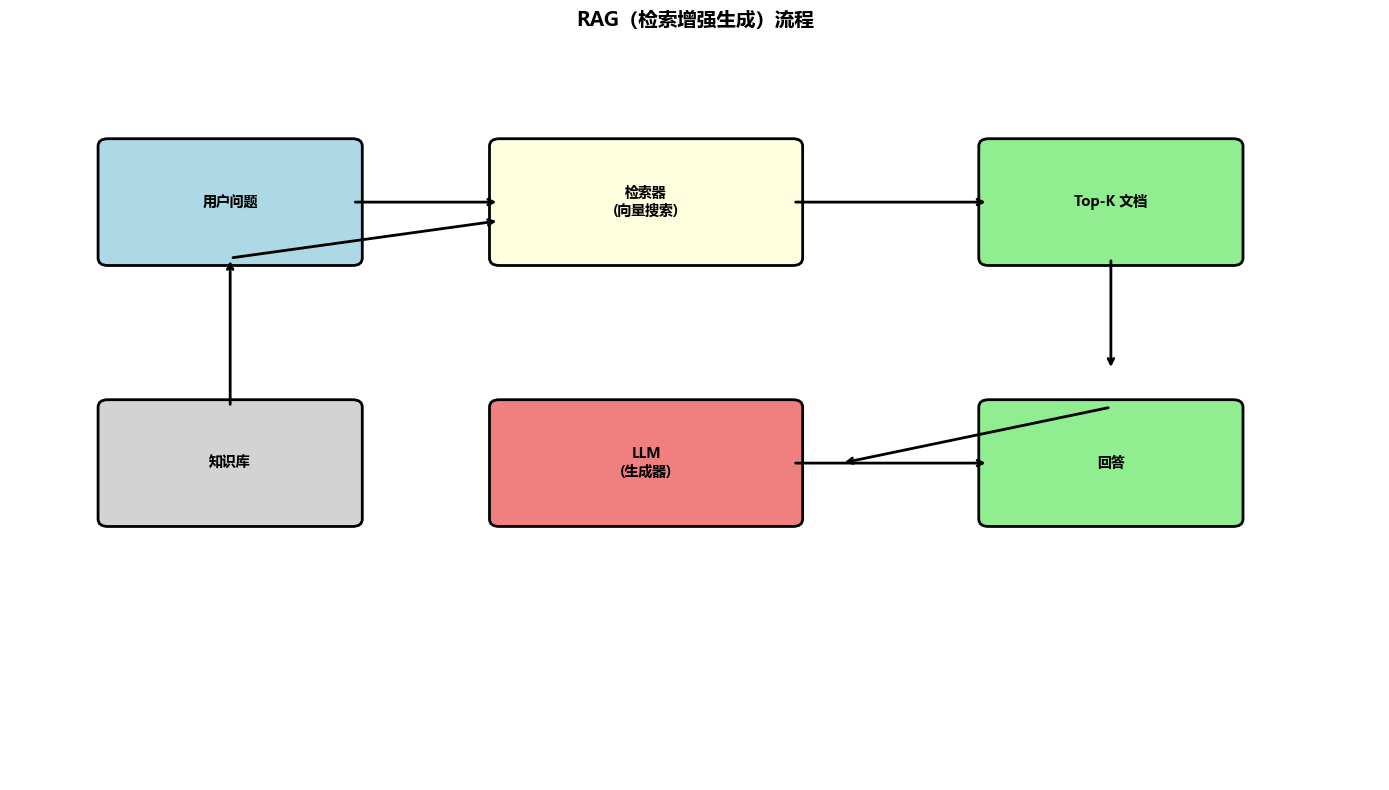

In [9]:
# 可视化 RAG 流程（中文）
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import font_manager

def pick_font(candidates):
    for name in candidates:
        try:
            font_manager.findfont(name, fallback_to_default=False)
            return name
        except Exception:
            continue
    return "DejaVu Sans"

FONT_FAMILY = pick_font([
    "Microsoft YaHei",
    "SimHei",
    "Noto Sans CJK SC",
    "PingFang SC",
    "Arial Unicode MS",
])

plt.rcParams["font.sans-serif"] = [FONT_FAMILY]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.unicode_minus"] = False

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

# 绘制流程框
boxes = [
    (1, 7, 2.5, 1.5, "用户问题", "lightblue"),
    (5, 7, 3, 1.5, "检索器\n(向量搜索)", "lightyellow"),
    (10, 7, 2.5, 1.5, "Top-K 文档", "lightgreen"),
    (5, 3.5, 3, 1.5, "LLM\n(生成器)", "lightcoral"),
    (10, 3.5, 2.5, 1.5, "回答", "lightgreen"),
    (1, 3.5, 2.5, 1.5, "知识库", "lightgray"),
]

for x, y, w, h, text, color in boxes:
    rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=10, fontweight='bold')

# 绘制箭头
arrows = [
    (3.5, 7.75, 5, 7.75),      # Query -> Retriever
    (8, 7.75, 10, 7.75),       # Retriever -> Docs
    (11.25, 7, 11.25, 5.5),    # Docs -> down
    (11.25, 5, 8.5, 4.25),     # -> LLM
    (8, 4.25, 10, 4.25),       # LLM -> Answer
    (2.25, 5, 2.25, 7),        # KB -> up
    (2.25, 7, 5, 7.5),         # -> Retriever
]

for x1, y1, x2, y2 in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.title('RAG（检索增强生成）流程', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---

## 5. Agent + RAG 结合

In [10]:
# 简单的 RAG 组件
import re

class SimpleRAG:
    def __init__(self):
        self.docs = [
            "PyTorch 是一个开源的机器学习框架，支持动态计算图。",
            "它提供 GPU 加速的张量计算与自动求导（autograd）。",
            "PyTorch 常用于深度学习研究与工业落地。",
            "TorchVision、TorchText 是常用生态库。",
            "RAG 会将检索到的文档拼接进提示词以减少幻觉。",
            "向量数据库用于高效相似度检索，如 FAISS、Milvus、Chroma。",
            "Agent 可以通过工具调用扩展外部能力，例如搜索、计算、API。",
        ]

    def _score(self, query: str, doc: str) -> float:
        q_tokens = set(re.findall(r"\w+", query.lower()))
        d_tokens = set(re.findall(r"\w+", doc.lower()))
        if not q_tokens:
            return 0.0
        return len(q_tokens & d_tokens) / max(len(q_tokens), 1)

    def retrieve(self, query: str, top_k: int = 2) -> list:
        ranked = sorted(self.docs, key=lambda d: self._score(query, d), reverse=True)
        return ranked[:top_k]

class RAGAgent:
    """
    结合 RAG 的 Agent
    """
    def __init__(self):
        self.rag = SimpleRAG()
        self.tools = {
            "search_knowledge_base": self.search_kb,
            "calculator": calculator,
        }

    def search_kb(self, query: str) -> str:
        """搜索知识库"""
        docs = self.rag.retrieve(query, top_k=2)
        return " | ".join(docs)

    def run(self, query: str):
        print(f"问题: {query}")
        print("=" * 60)

        # 模拟 Agent 决定使用 RAG
        print("\nThought: 我应该查询知识库获取信息。")
        print(f"Action: search_knowledge_base(query=\"{query}\")")

        result = self.search_kb(query)
        print(f"Observation: {result[:100]}...")

        print("\nThought: 已获取足够信息，可以回答。")
        print("Final Answer: PyTorch 是一个机器学习框架，支持 GPU 加速与自动求导。")

# 测试
rag_agent = RAGAgent()
rag_agent.run("请介绍一下 PyTorch")


问题: 请介绍一下 PyTorch

Thought: 我应该查询知识库获取信息。
Action: search_knowledge_base(query="请介绍一下 PyTorch")
Observation: PyTorch 是一个开源的机器学习框架，支持动态计算图。 | PyTorch 常用于深度学习研究与工业落地。...

Thought: 已获取足够信息，可以回答。
Final Answer: PyTorch 是一个机器学习框架，支持 GPU 加速与自动求导。


---

## 本章总结

1. **ReAct 范式**
   - Thought → Action → Observation 循环
   - 让 LLM 具备规划和执行能力

2. **Tool Use**
   - 定义清晰的工具接口
   - 让 LLM 输出结构化的调用指令

3. **RAG**
   - 检索相关文档增强回答
   - 解决 LLM 知识过时问题

4. **Agent + RAG**
   - 结合两者的优势
   - 构建更强大的系统

### 课程总结

恭喜完成所有章节！你已经学习了：
- Ch0-Ch5: 从零构建神经网络和 Transformer
- Ch6-Ch7: 训练流水线
- Ch8-Ch10: 对齐和微调技术
- Ch11: 推理优化（KV Cache）
- Ch12: Agent 和 RAG 系统

### ../Applications 为更多真实Agent构造案例

---

## 练习题

1. **扩展工具集**：添加更多工具（如天气 API、翻译等）
2. **实现向量检索**：使用真正的向量数据库
3. **构建完整 Agent**：接入真实的 LLM API

In [11]:
# 练习空间

